In [1]:
import numpy as np
from astropy.io import ascii
from functions import *
from scipy.optimize import curve_fit
from sklearn import neighbors
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pickle

In [2]:
print("loading data")
cols = ['Mstar',
        'u_r', 'g_r',
        'rabsmag',
        'SFR', 'sSFR', 'redshift',
        'flag_vsquared',
        'flag_voidfinder']

data = ascii.read('data_flags_updated_Jul31.dat', include_names=cols)

Mstar = data['Mstar']
# color
u_r = data['u_r']
g_r = data['g_r']
# absolute magnitude
rabsmag = data['rabsmag']
#star formation rate and specific SPR
SFR  = np.array(data['SFR'])
sSFR = np.array(data['sSFR'])

print("loading classification")
#classification V^2
wall_v2 = np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = np.argwhere(data['flag_vsquared'] == 9).flatten()

#classification voidfinder
wall_vf = np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = np.argwhere(data['flag_voidfinder'] == 9).flatten()

loading data
loading classification


In [54]:
ind_gal_depth_voidv2 = np.load('ind_gal_depth_voidv2_50_log_e.npy', allow_pickle=True)


In [55]:
def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    '''returns a mixture of two skewnormal distributions'''
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)


In [56]:
def func_bimodal1(x, a, mua, sga, askew):
    '''returns a mixture of two skewnormal distributions'''
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) 

In [57]:
def bin_data(data,bins_,label, plot=False): 

    n1, edges1 = np.histogram(data, bins=bins_)
    dn1 = np.sqrt(n1)
    x = 0.5*(edges1[1:] + edges1[:-1])
        
    if plot == True:
        plt.errorbar(x, n1, yerr=dn1, fmt='.')        
        plt.xlabel(label, fontsize=18)
        plt.ylabel('count',fontsize=18) 
        plt.title("Binned Data ")
        plt.show()
            
# #     popt_wall, pcov_wall = curve_fit(func_bimodal, x, count_wall)
#     popt_void, pcov_void = curve_fit(func_bimodal, x, n1)

        
#     plt.errorbar(x, n1, yerr=dn1, fmt='.')  
#     plt.plot(x, func_bimodal(x, *popt_void), 'r-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
#     plt.title(label + " Void")
#     plt.xlabel(label)
#     plt.ylabel("Counts")
#     plt.show()
    
#     print(popt_void)
#     print(*popt_void)
        
    return  x,n1,dn1 #, popt_void

In [58]:
def bimodal_fit_void_separate(char_void, label, bins_):
    '''
    for example: char_= g_r, char_label= 'g-r', bins_=np.linspace(-0.5,1.5, 250)
    '''
    ## property variables
    print("loading property model variables")
    label_vf = label+'_VF'
    label_v2 = label+'_V2'
    
    
#     x, count_wall,dcount_wall = bin_data(char_wall,bins_,label)
    x, count_void,dcount_void = bin_data(char_void,bins_,label)
    
#     popt_wall, pcov_wall = curve_fit(func_bimodal, x, count_wall)
    popt_void, pcov_void = curve_fit(func_bimodal, x, count_void)

        
    plt.errorbar(x, count_void, yerr=dcount_void, fmt='.')  
    plt.plot(x, func_bimodal1(x, *popt_void[:4]), 'r-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.plot(x, func_bimodal1(x, *popt_void[4:]), 'g-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.plot(x, func_bimodal(x, *popt_void), 'black') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))

    plt.title(label + " Void")
    plt.xlabel(label)
    plt.ylabel("Counts")
    plt.show()
 

    plt.plot(x,func_bimodal(x, *popt_void)-count_void)
    plt.ylim(-np.max(count_void)/5,np.max(count_void)/5)
    plt.title('residuals')
    plt.show()
    
    return popt_void, np.sqrt(np.diag(pcov_void))
    

loading property model variables


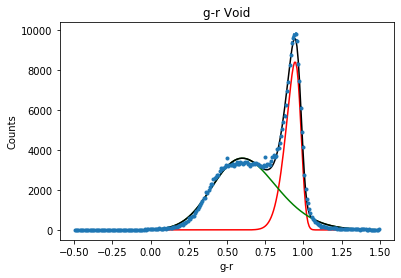

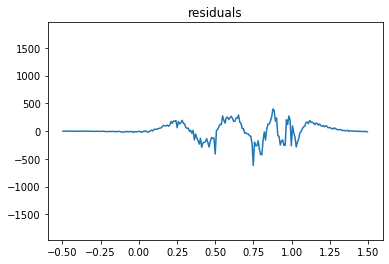

In [59]:
fit_all = bimodal_fit_void_separate(g_r[data['redshift']< 0.1026], 'g-r', bins_=np.linspace(-0.5,1.5, 250))


In [114]:
#amplitudes
fit_all[0][0], fit_all[0][4]


(1052.9903866793168, 1912.3963234746336)

loading property model variables


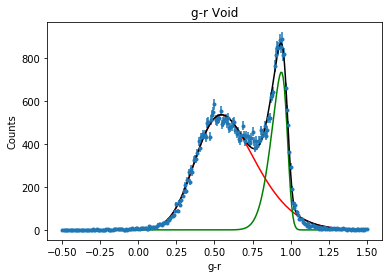

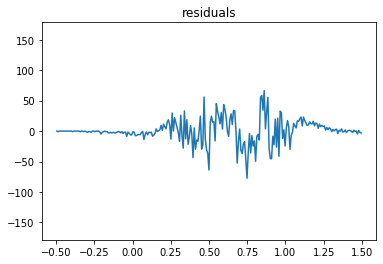

In [61]:
VF_void = bimodal_fit_void_separate(g_r[void_vf], 'g-r', bins_=np.linspace(-0.5,1.5, 250))


In [62]:
def bimodal_fit_void(char_void, label, bins_):
    '''
    for example: char_= g_r, char_label= 'g-r', bins_=np.linspace(-0.5,1.5, 250)
    '''
    ## property variables
    print("loading property model variables")
    label_vf = label+'_VF'
    label_v2 = label+'_V2'
    
    
#     x, count_wall,dcount_wall = bin_data(char_wall,bins_,label)
    x, count_void,dcount_void = bin_data(char_void,bins_,label)
    
#     popt_wall, pcov_wall = curve_fit(func_bimodal, x, count_wall)
    popt_void, pcov_void = curve_fit(func_bimodal, x, count_void)

        
    plt.errorbar(x, count_void, yerr=dcount_void, fmt='.')  
    plt.plot(x, func_bimodal(x, *popt_void), 'r-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.title(label + " Void")
    plt.xlabel(label)
    plt.ylabel("Counts")
    plt.show()
    
    plt.plot(x,func_bimodal(x, *popt_void)-count_void)
    plt.ylim(-np.max(count_void)/5,np.max(count_void)/5)
    plt.title('residuals')
    plt.show()
    
    return popt_void, np.sqrt(np.diag(pcov_void))
    

In [63]:
def ampl_ratio_err(x,dx,y,dy):
    '''
    returns the standard deviation of x/y
    '''
    return np.sqrt((dx/y)**2+((x*dy)/(y**2))**2)
    
def ampl_diff_err(dx,dy):
    '''
    returns the standard deviation of x-y
    '''
    return np.sqrt(dx**2 + dy**2)    

0
loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


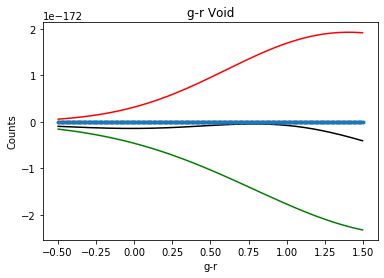

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/ipykernel/__main__.py:30: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


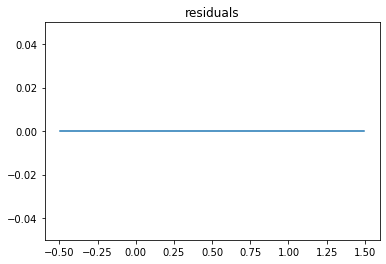

1
loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


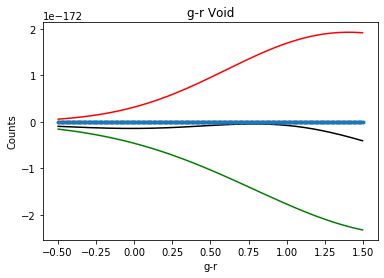

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/ipykernel/__main__.py:30: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


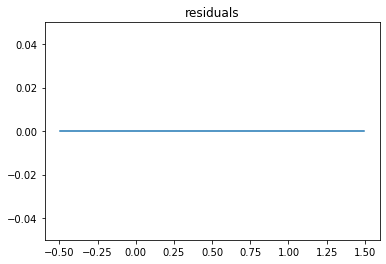

2
loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


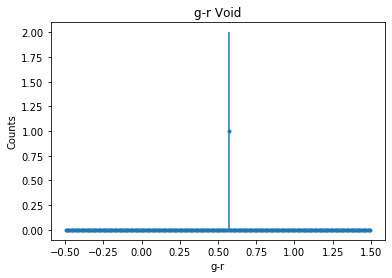

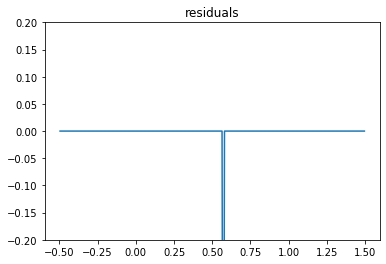

3
loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


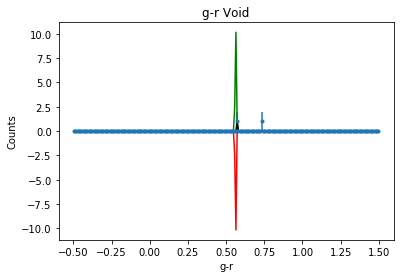

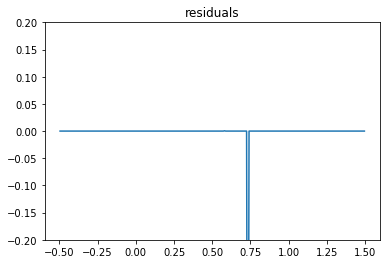

4
loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


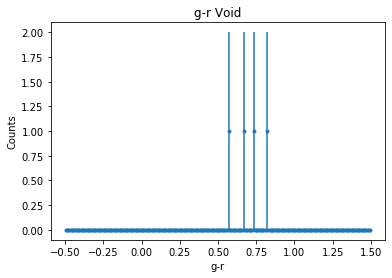

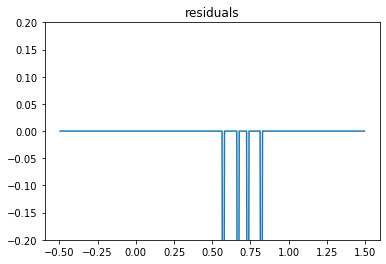

5
loading property model variables
6
loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


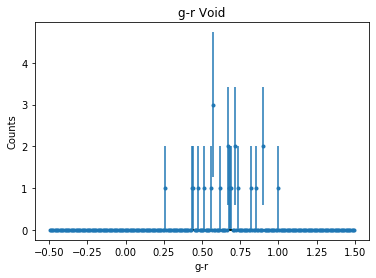

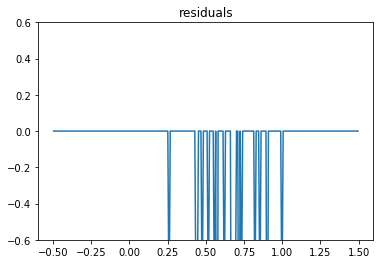

7
loading property model variables
8
loading property model variables
9
loading property model variables


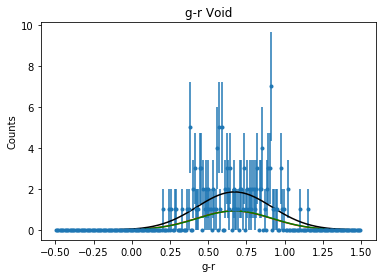

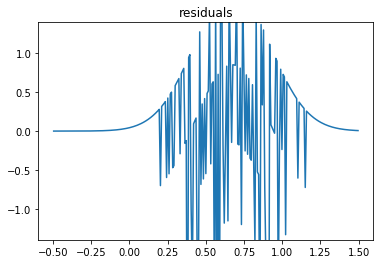

10
loading property model variables


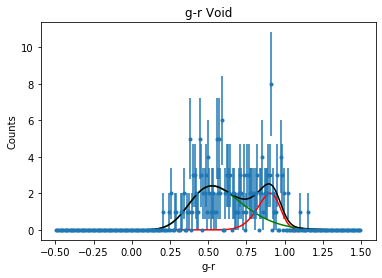

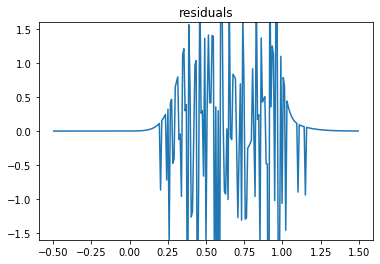

11
loading property model variables


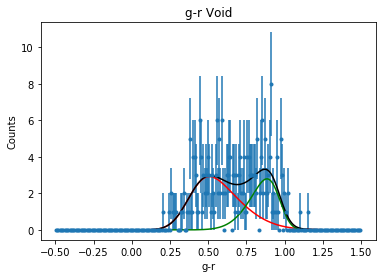

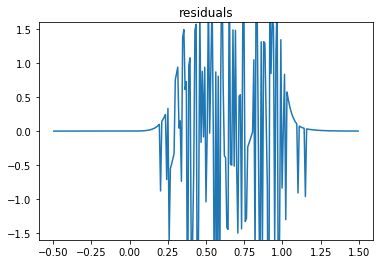

12
loading property model variables


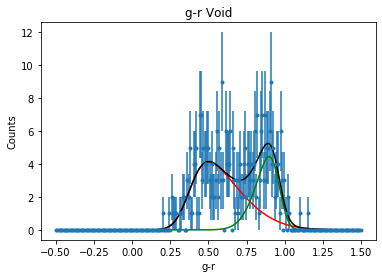

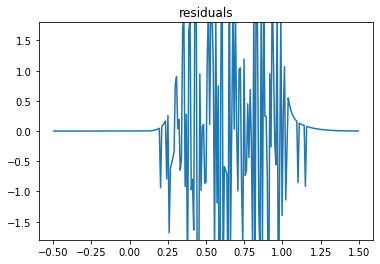

13
loading property model variables


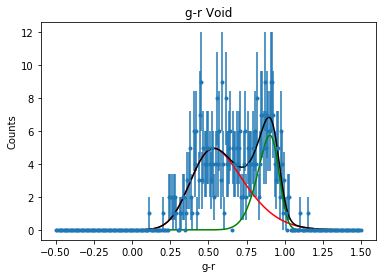

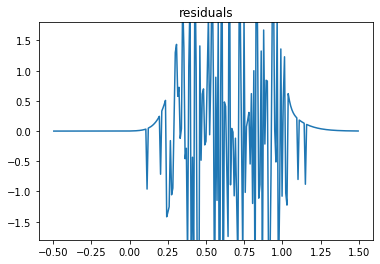

14
loading property model variables


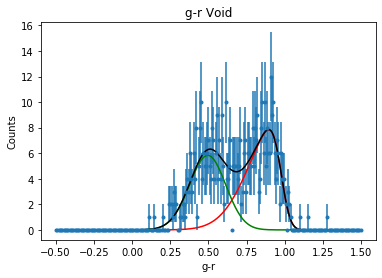

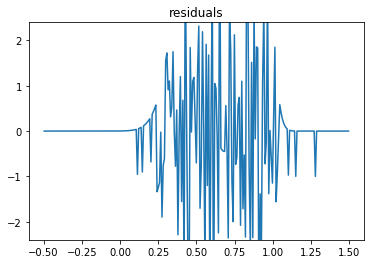

15
loading property model variables


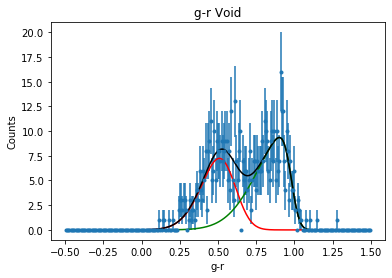

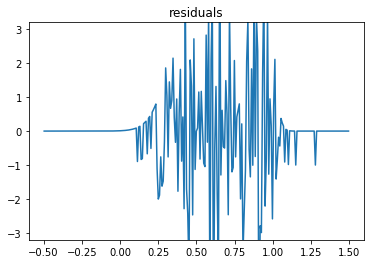

16
loading property model variables


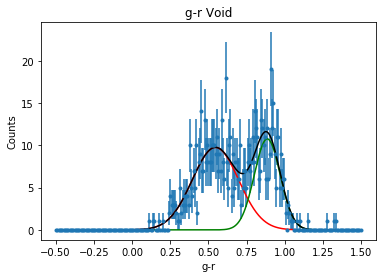

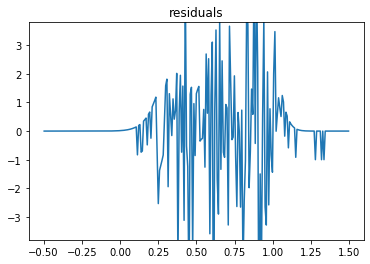

17
loading property model variables


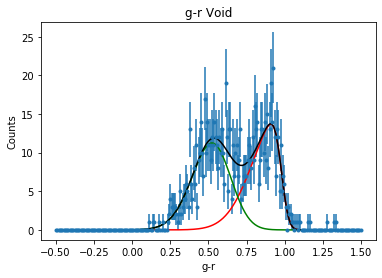

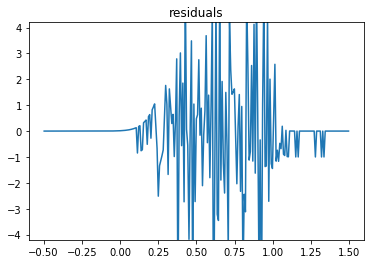

18
loading property model variables


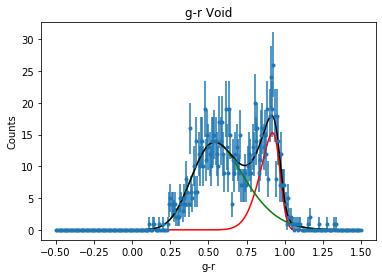

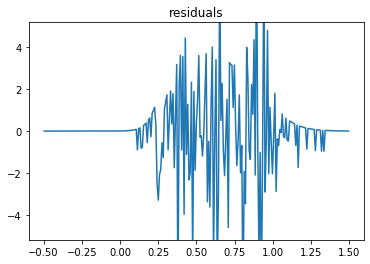

19
loading property model variables


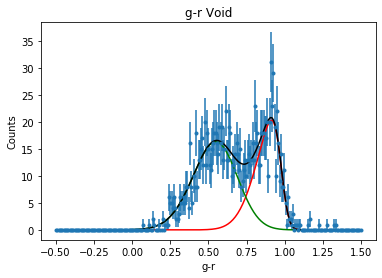

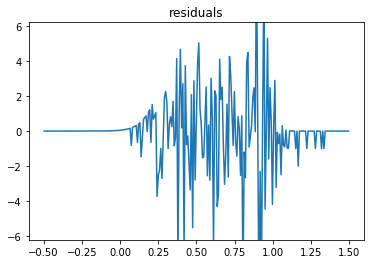

20
loading property model variables


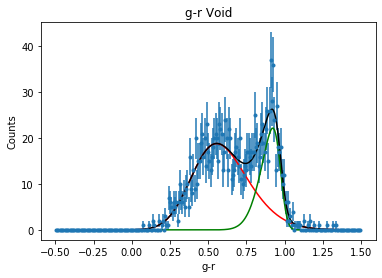

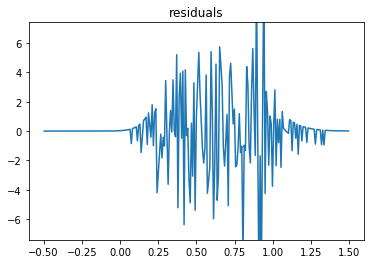

21
loading property model variables


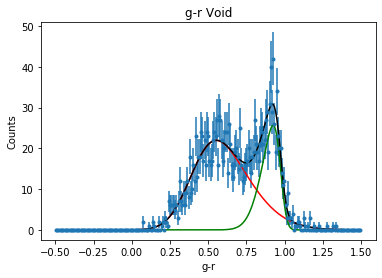

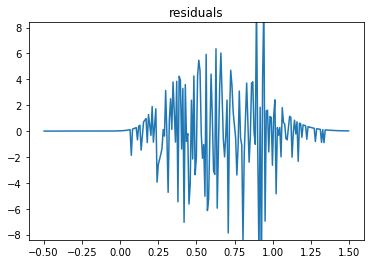

22
loading property model variables


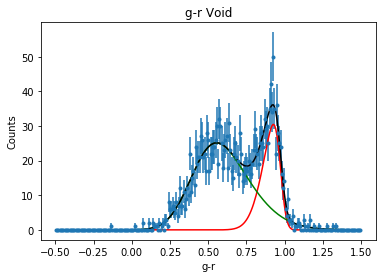

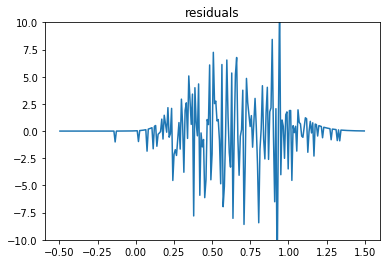

23
loading property model variables


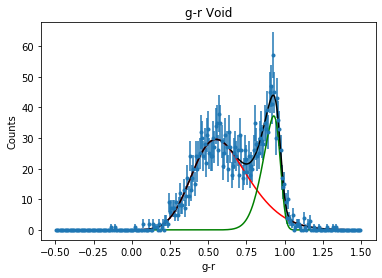

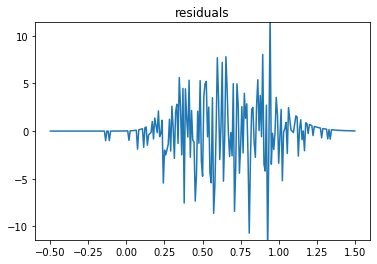

24
loading property model variables


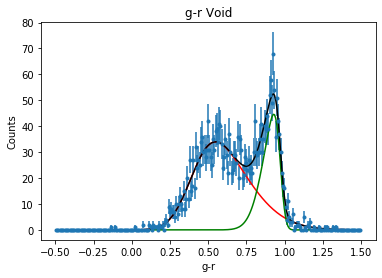

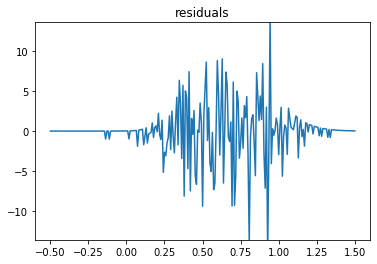

25
loading property model variables


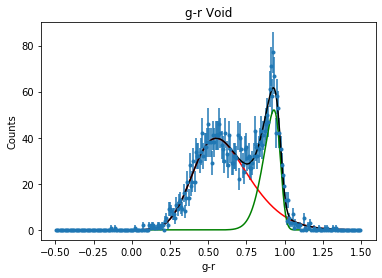

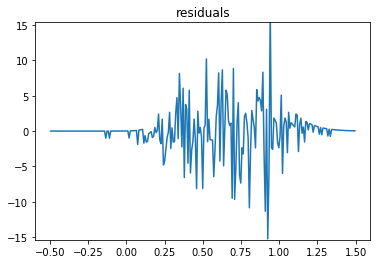

26
loading property model variables


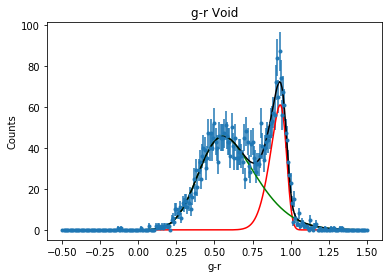

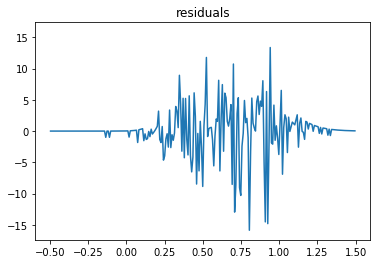

27
loading property model variables


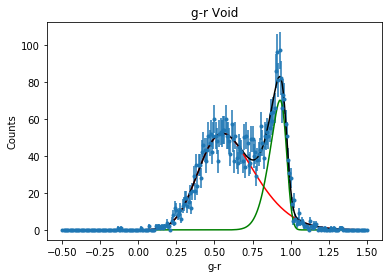

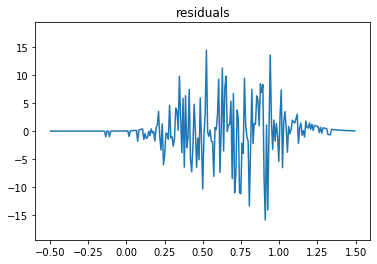

28
loading property model variables


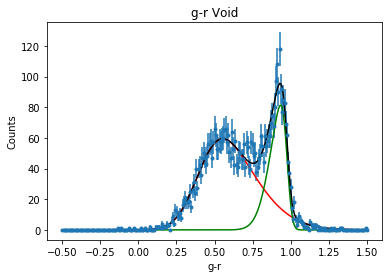

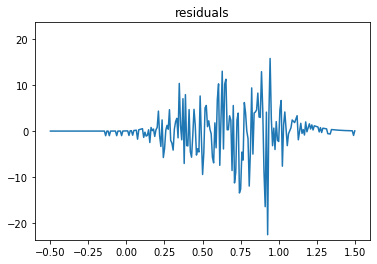

29
loading property model variables


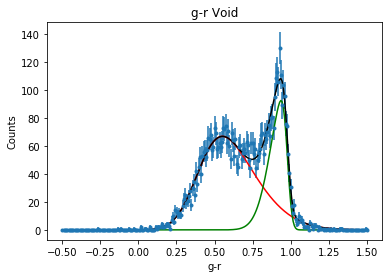

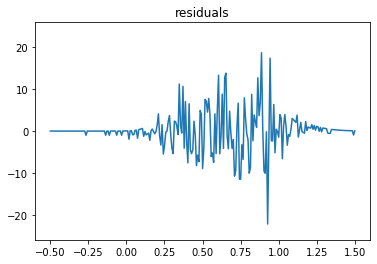

30
loading property model variables


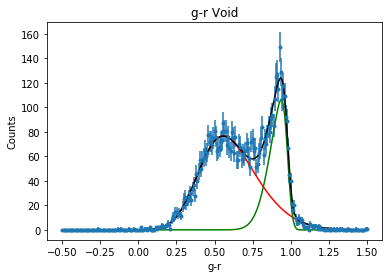

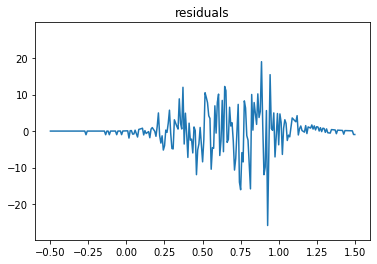

31
loading property model variables


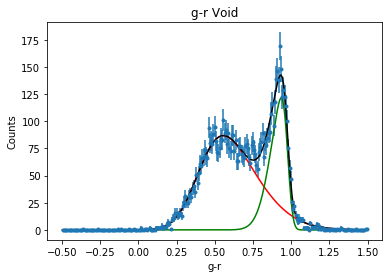

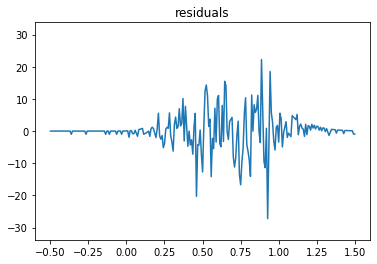

32
loading property model variables


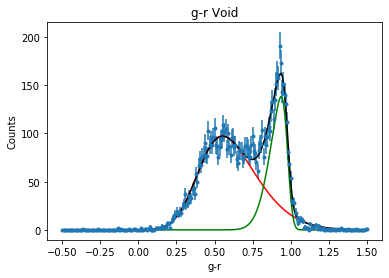

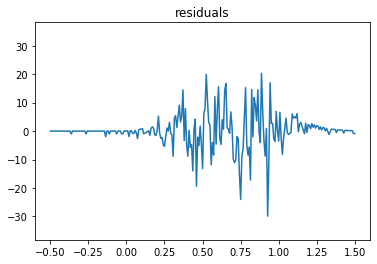

33
loading property model variables


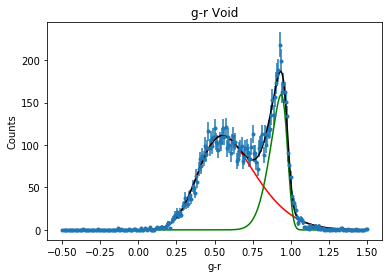

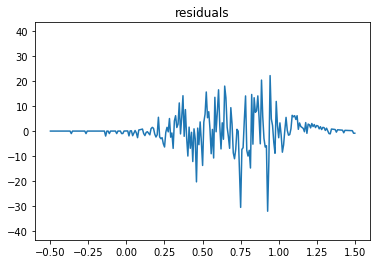

34
loading property model variables


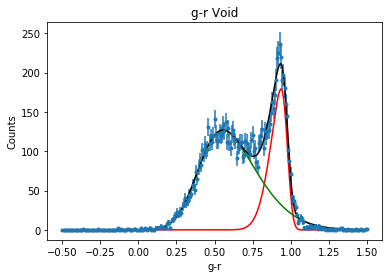

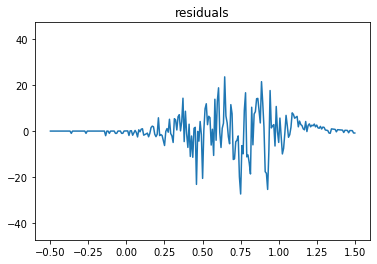

35
loading property model variables


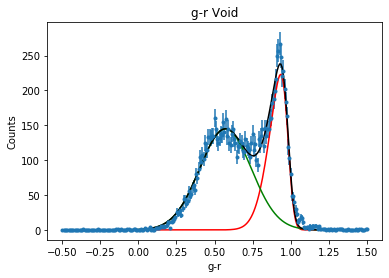

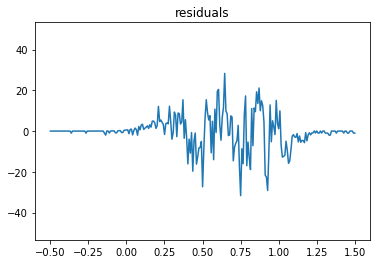

36
loading property model variables


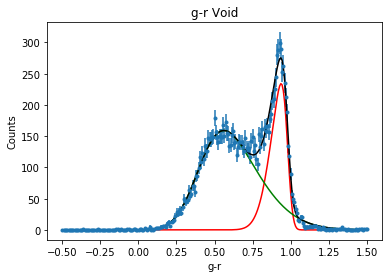

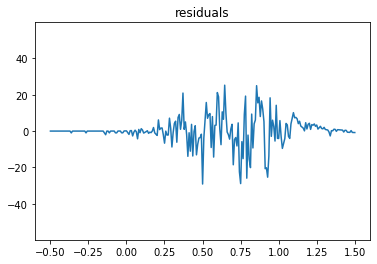

37
loading property model variables


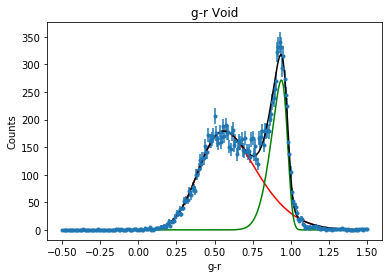

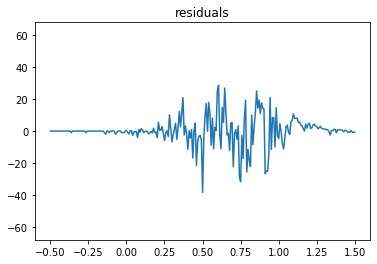

38
loading property model variables


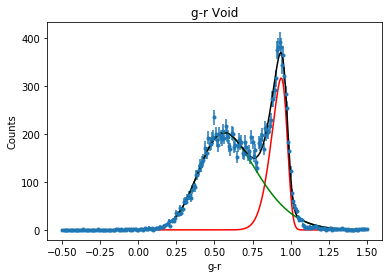

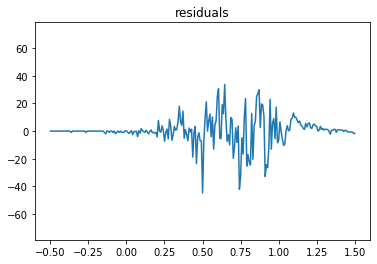

39
loading property model variables
40
loading property model variables


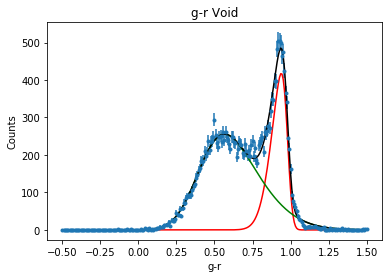

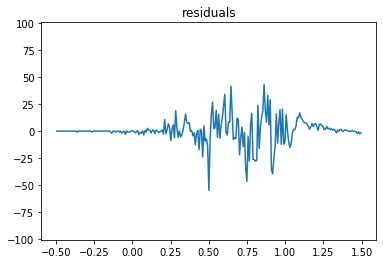

41
loading property model variables


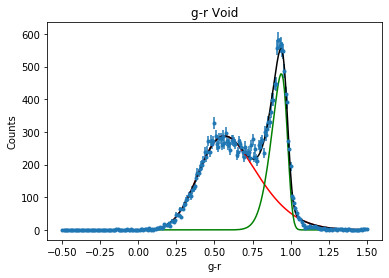

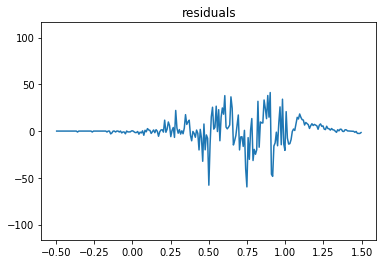

42
loading property model variables
43
loading property model variables


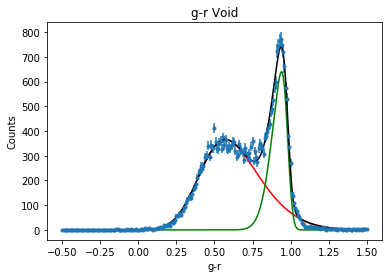

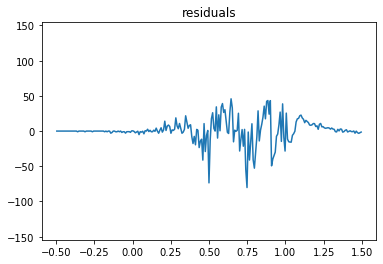

44
loading property model variables


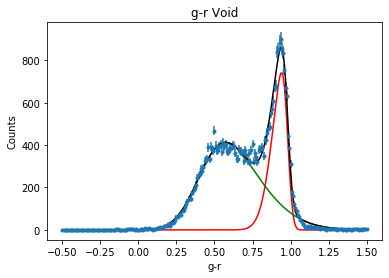

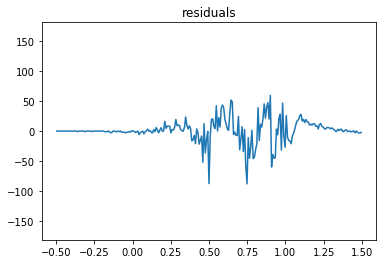

45
loading property model variables


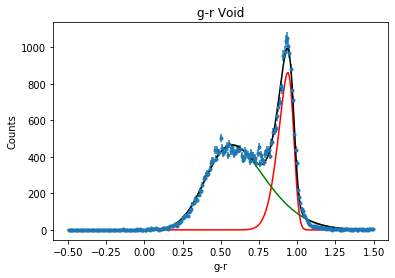

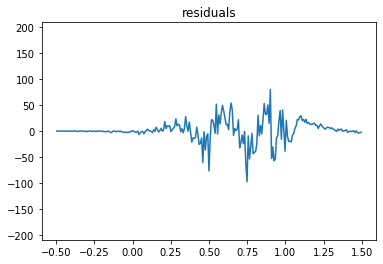

46
loading property model variables


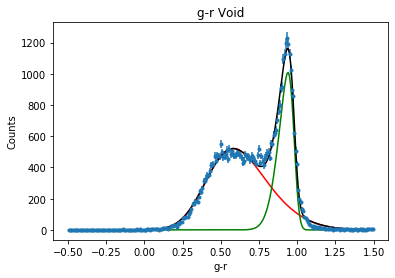

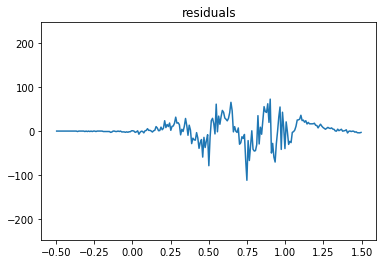

47
loading property model variables


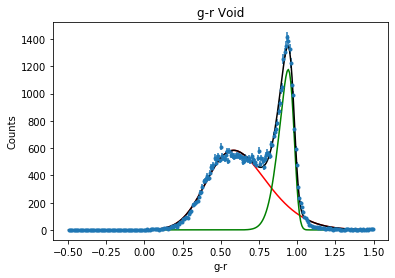

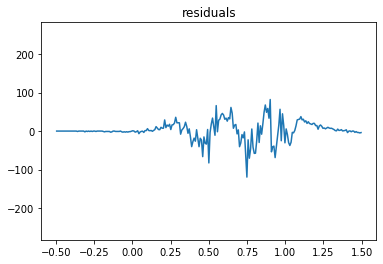

48
loading property model variables


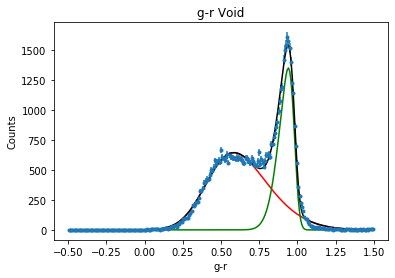

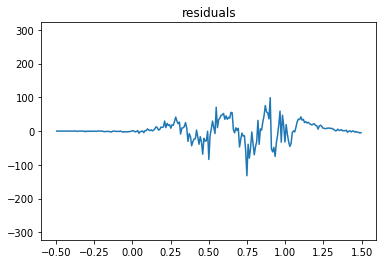

49
loading property model variables


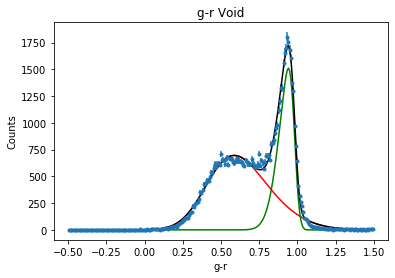

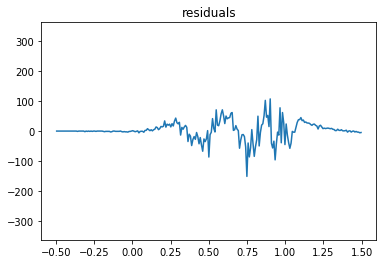

50
loading property model variables


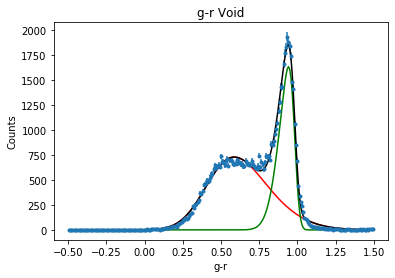

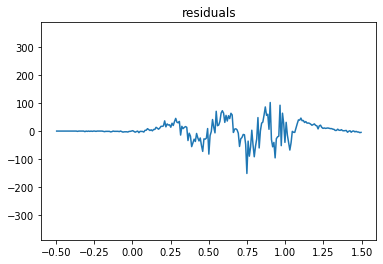

51
loading property model variables


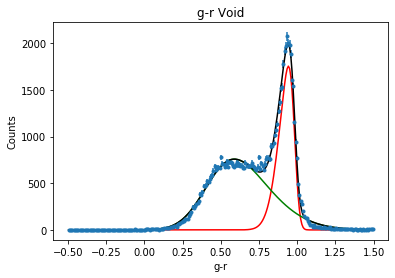

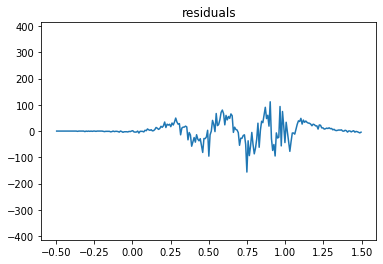

In [64]:
#normalized by the general distribution
amplitude_ratio = []
amplitude_ratio_err = []

amplitude_diff = []
amplitude_diff_err = []
for i in range(len(ind_gal_depth_voidv2)):
    print(i)
    try:
        temp = bimodal_fit_void_separate(g_r[np.asarray(list(ind_gal_depth_voidv2[i]), dtype=int).flatten()], 'g-r', bins_=np.linspace(-0.5,1.5, 250))
        x = np.max([temp[0][4],temp[0][0]])
        y = np.min([temp[0][4],temp[0][0]])
        if x == temp[0][4]:
            dx = temp[1][4]/np.max([fit_all[0][4],fit_all[0][0]])
            dy = temp[1][0]/np.min([fit_all[0][4],fit_all[0][0]])

        if x == temp[0][0]:
            dx = temp[1][0]/np.max([fit_all[0][4],fit_all[0][0]])
            dy = temp[1][4]/np.min([fit_all[0][4],fit_all[0][0]])
            
        x = x/np.max([fit_all[0][4],fit_all[0][0]])
        y = y/np.min([fit_all[0][4],fit_all[0][0]])
        
        amplitude_ratio.append(x/y)
        amplitude_diff.append(x-y)
        amplitude_ratio_err.append(ampl_ratio_err(x,dx,y,dy))
        amplitude_diff_err.append(ampl_diff_err(dx,dy))
        
    except (RuntimeError):
        pass


In [65]:
amplitude_ratio = np.array(amplitude_ratio)
amplitude_ratio_err = np.array(amplitude_ratio_err)
amplitude_diff = np.array(amplitude_diff)
amplitude_diff_err = np.array(amplitude_diff_err)

In [105]:
# voidfinder line
x_vf_void = np.max([VF_void[0][4],VF_void[0][0]])
y_vf_void = np.min([VF_void[0][4],VF_void[0][0]])
if x_vf_void == VF_void[0][4]:
    dx_vf_void = VF_void[1][4]/np.max([fit_all[0][4],fit_all[0][0]])
    dy_vf_void = VF_void[1][0]/np.min([fit_all[0][4],fit_all[0][0]])

if x_vf_void == VF_void[0][0]:
    dx_vf_void = VF_void[1][0]/np.max([fit_all[0][4],fit_all[0][0]])
    dy_vf_void = VF_void[1][4]/np.min([fit_all[0][4],fit_all[0][0]])

x_vf_void = x_vf_void/np.max([fit_all[0][4],fit_all[0][0]])
y_vf_void = y_vf_void/np.min([fit_all[0][4],fit_all[0][0]])

vf_void_ratio = x_vf_void/y_vf_void
vf_void_diff = (x_vf_void-y_vf_void)
vf_void_ratio_err= (ampl_ratio_err(x_vf_void,dx_vf_void,y_vf_void,dy_vf_void))
vf_void_diff_err= (ampl_diff_err(dx_vf_void,dy_vf_void))

In [106]:
ind_ratio=8 # choose
x_ratio = np.linspace(0,len(amplitude_ratio[ind_ratio:]),len(amplitude_ratio[ind_ratio:]))

ind_diff=8 # choose
x_diff = np.linspace(0,len(amplitude_diff[ind_diff:]),len(amplitude_diff[ind_diff:]))

In [107]:
y_vf_void_ratio = []
y_vf_void_ratio_err=[]
for i in range(len(x_ratio)):
    y_vf_void_ratio.append(vf_void_ratio)
    y_vf_void_ratio_err.append(vf_void_ratio_err)
    
y_vf_void_diff = []
y_vf_void_diff_err=[]
for i in range(len(x_diff)):
    y_vf_void_diff.append(vf_void_diff)
    y_vf_void_diff_err.append(vf_void_diff_err)

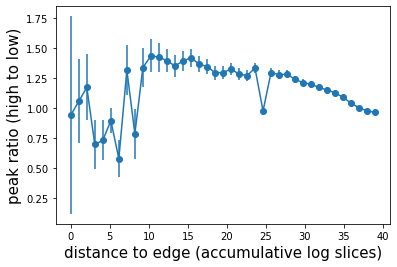

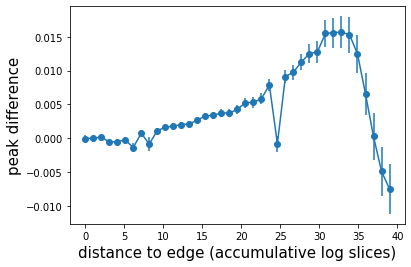

In [113]:
plt.errorbar(x_ratio,amplitude_ratio[ind_ratio:],yerr=amplitude_ratio_err[ind_ratio:] ,fmt= '-o')
plt.xlabel("distance to edge (accumulative log slices)",fontsize=15)
plt.ylabel("peak ratio (high to low)",fontsize=15)
plt.show()


plt.errorbar(x_diff,amplitude_diff[ind_diff:],yerr=amplitude_diff_err[ind_diff:] ,fmt= '-o')
# error bars get bigger as x,y gets bigger
plt.xlabel("distance to edge (accumulative log slices)",fontsize=15)
plt.ylabel("peak difference",fontsize=15)
plt.show()

In [109]:
len(x_ratio), len(y_vf_void_diff)

(39, 39)

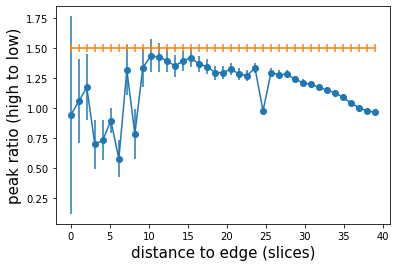

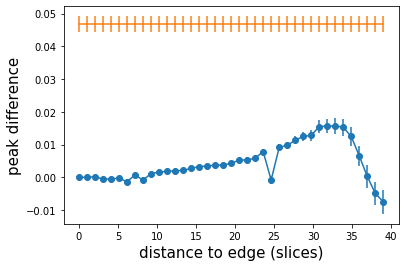

In [112]:
# x_ratio = np.linspace(0,len(amplitude_ratio[ind_ratio:]),len(amplitude_ratio[ind_ratio:]))


plt.errorbar(x_ratio,amplitude_ratio[ind_ratio:],yerr=amplitude_ratio_err[ind_ratio:] ,fmt= '-o')
plt.errorbar(x_ratio,y_vf_void_ratio,yerr=y_vf_void_ratio_err)

plt.xlabel("distance to edge (slices)",fontsize=15)
plt.ylabel("peak ratio (high to low)",fontsize=15)
plt.show()


# plt.errorbar(x_diff,np.abs(amplitude_diff[ind_diff:]),yerr=amplitude_diff_err[ind_diff:] ,fmt= '-o')
plt.errorbar(x_diff,amplitude_diff[ind_diff:],yerr=amplitude_diff_err[ind_diff:] ,fmt= '-o')

plt.errorbar(x_ratio,y_vf_void_diff,yerr=y_vf_void_diff_err)

# error bars get bigger as x,y gets bigger
plt.xlabel("distance to edge (slices)",fontsize=15)
plt.ylabel("peak difference",fontsize=15)
plt.show()

0
loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


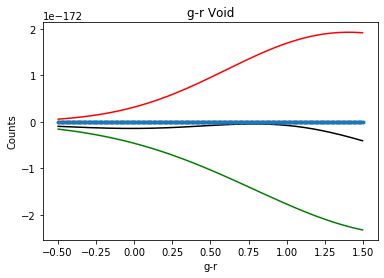

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/ipykernel/__main__.py:30: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


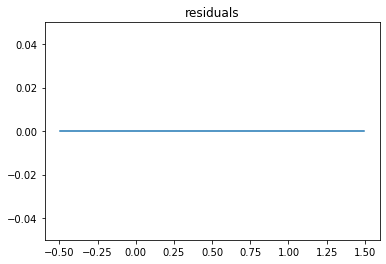

1
loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


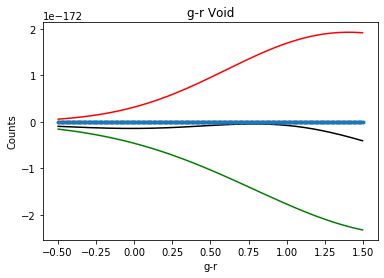

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/ipykernel/__main__.py:30: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


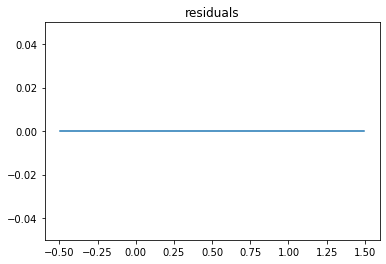

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


2
loading property model variables


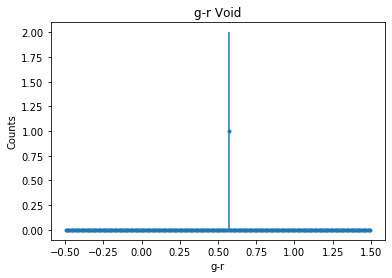

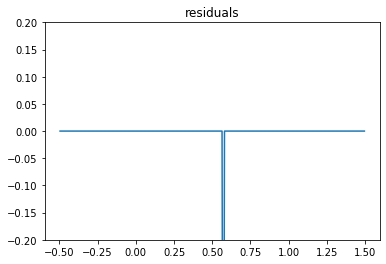

3
loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


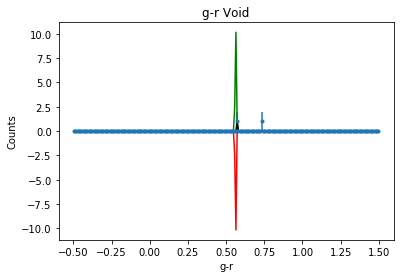

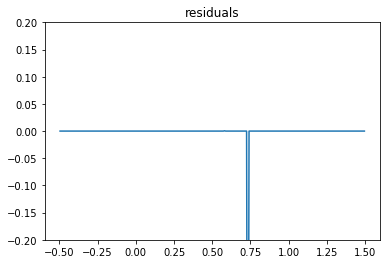

4
loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


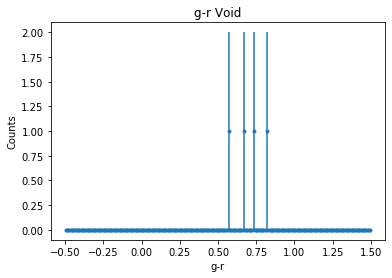

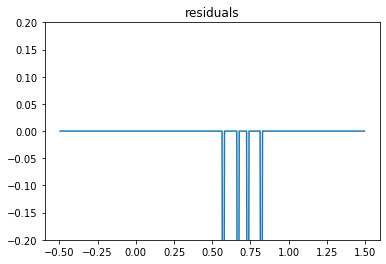

5
loading property model variables
6
loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


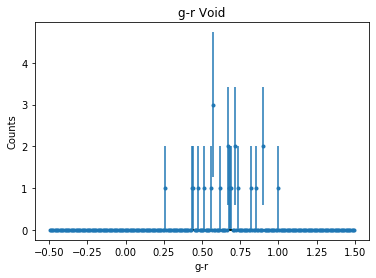

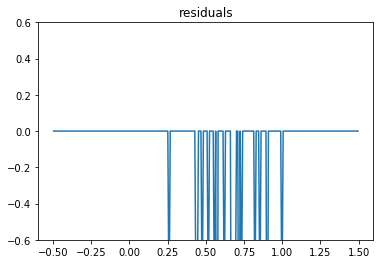

7
loading property model variables
8
loading property model variables
9
loading property model variables


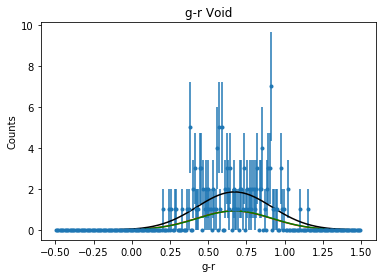

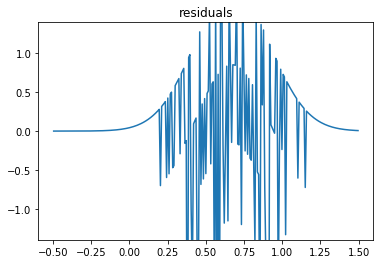

10
loading property model variables


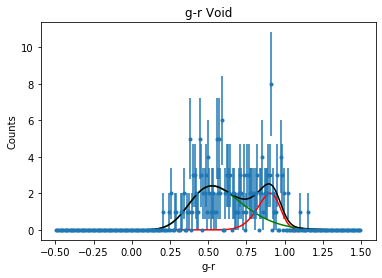

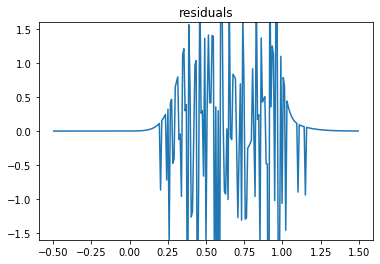

11
loading property model variables


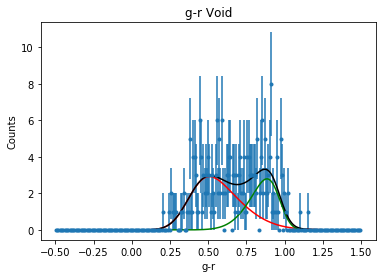

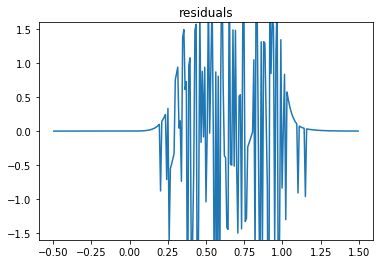

12
loading property model variables


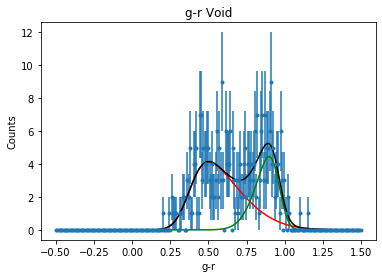

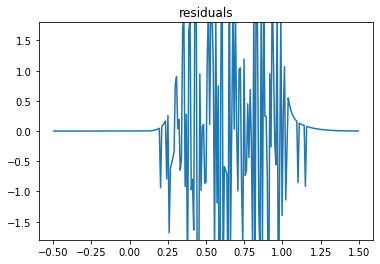

13
loading property model variables


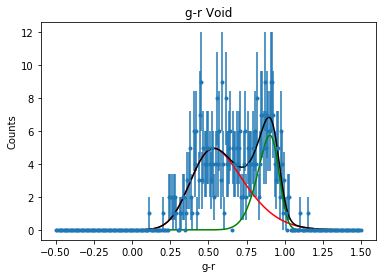

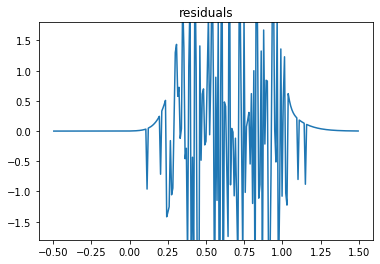

14
loading property model variables


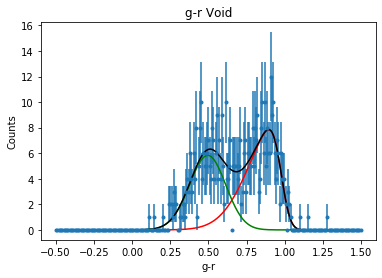

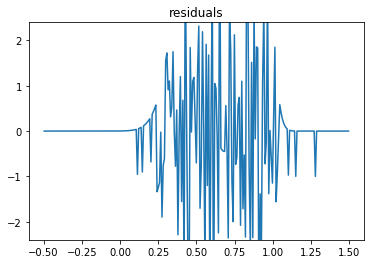

15
loading property model variables


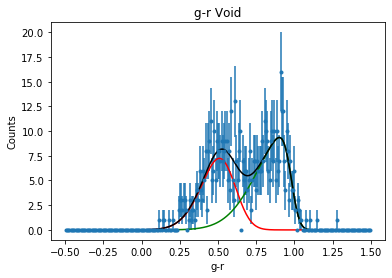

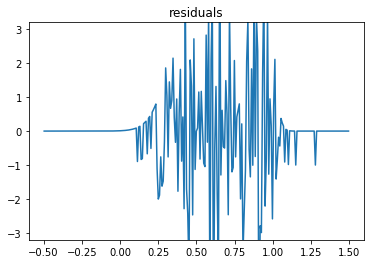

16
loading property model variables


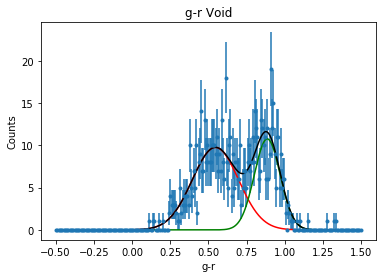

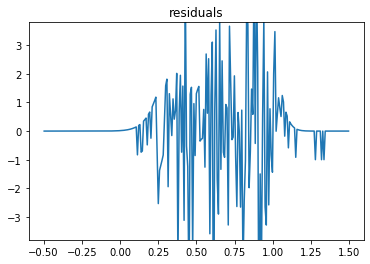

17
loading property model variables


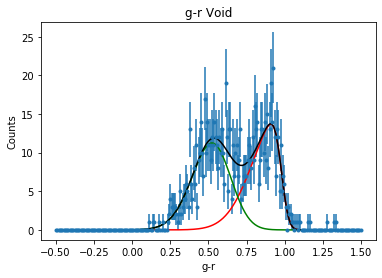

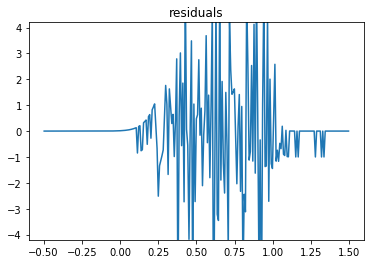

18
loading property model variables


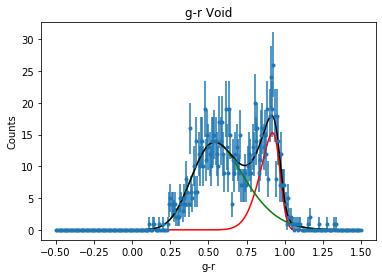

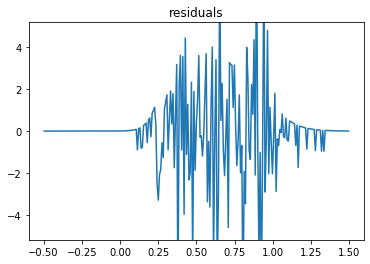

19
loading property model variables


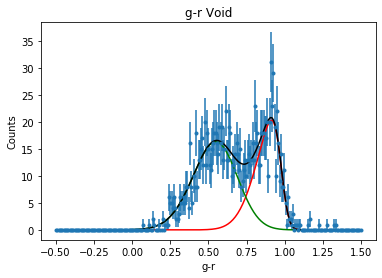

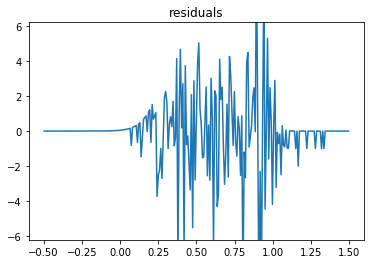

20
loading property model variables


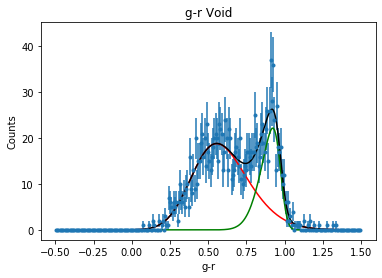

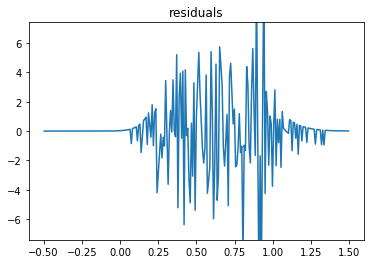

21
loading property model variables


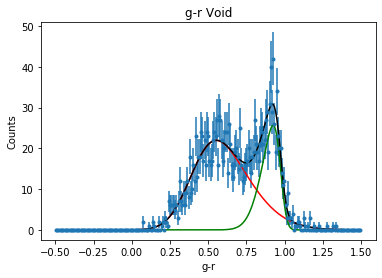

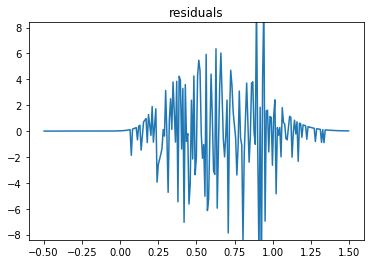

22
loading property model variables


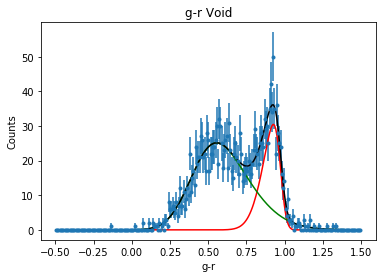

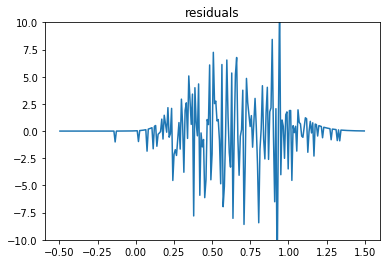

23
loading property model variables


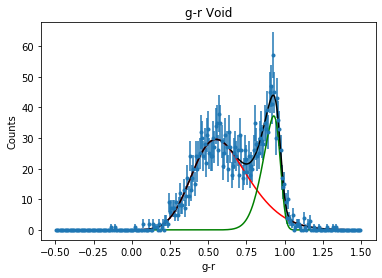

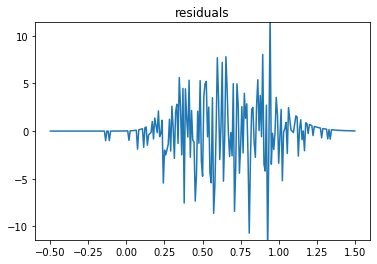

24
loading property model variables


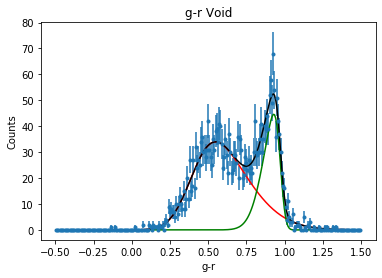

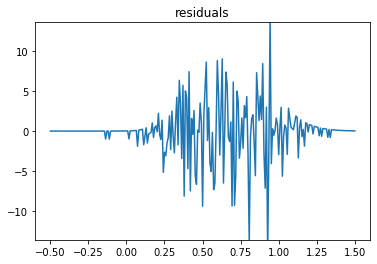

25
loading property model variables


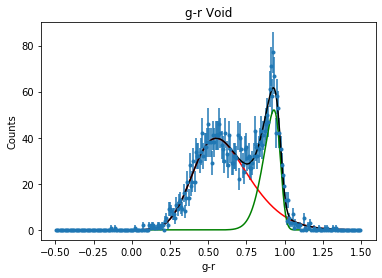

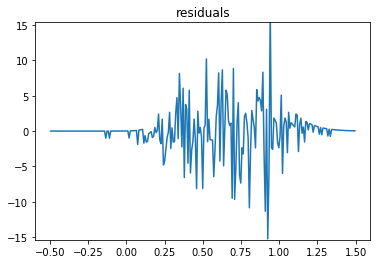

26
loading property model variables


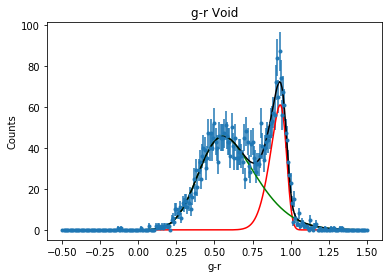

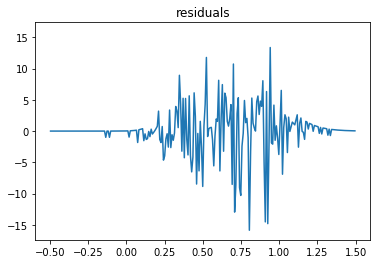

27
loading property model variables


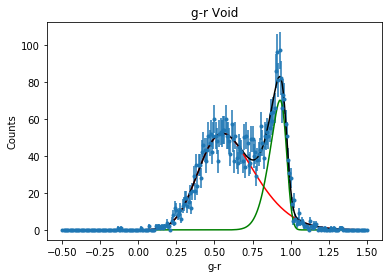

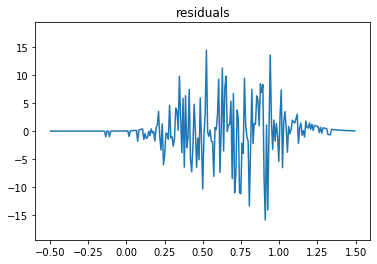

28
loading property model variables


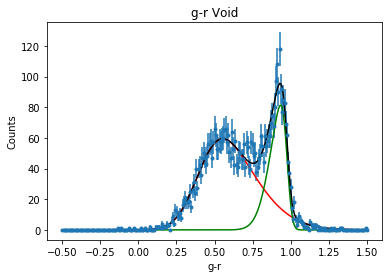

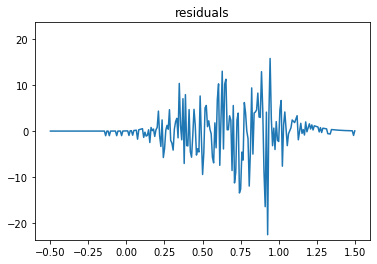

29
loading property model variables


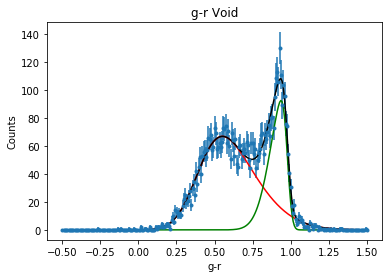

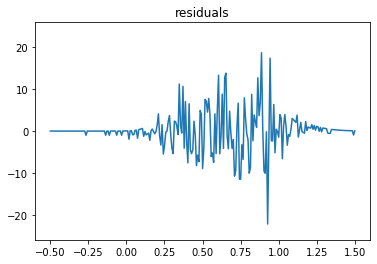

30
loading property model variables


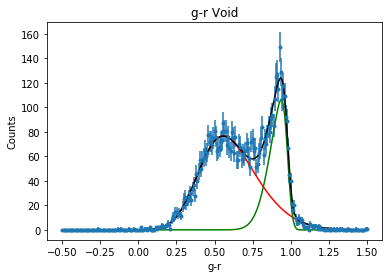

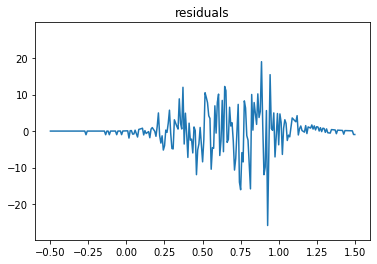

31
loading property model variables


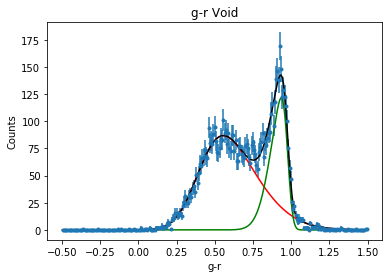

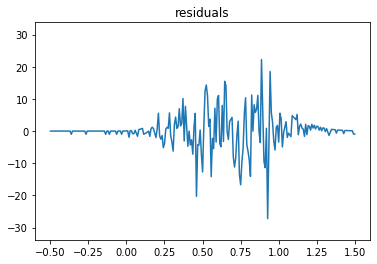

32
loading property model variables


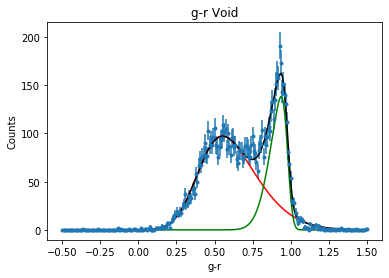

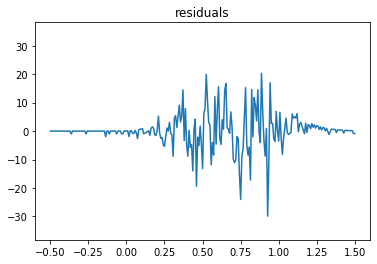

33
loading property model variables


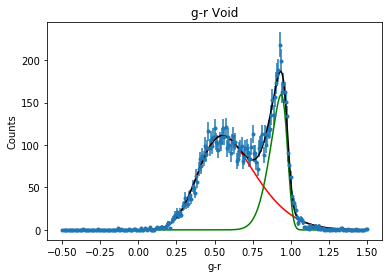

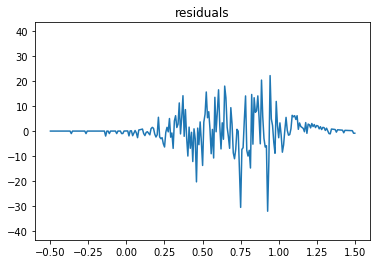

34
loading property model variables


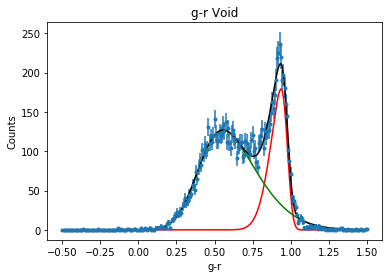

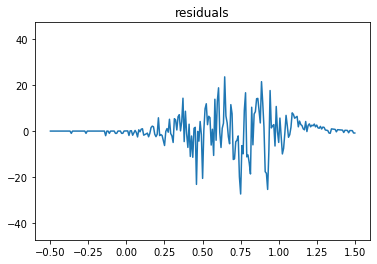

35
loading property model variables


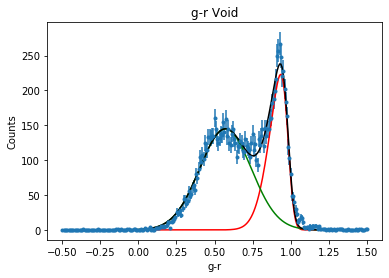

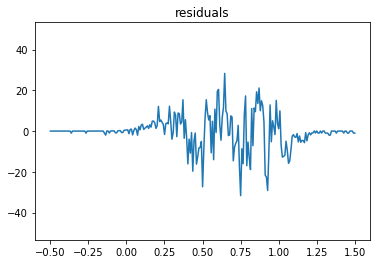

36
loading property model variables


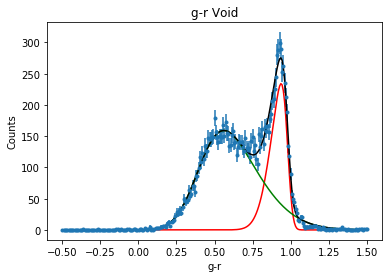

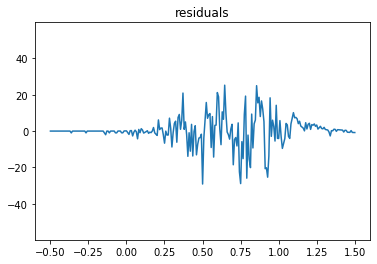

37
loading property model variables


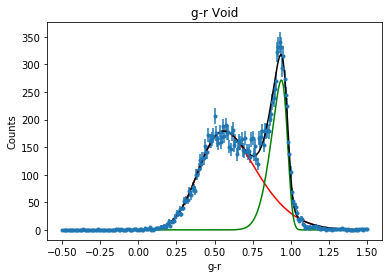

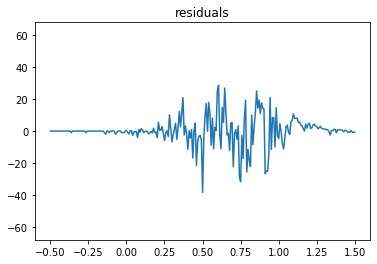

38
loading property model variables


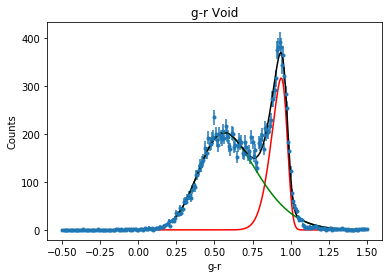

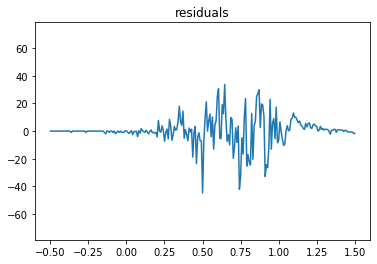

39
loading property model variables
40
loading property model variables


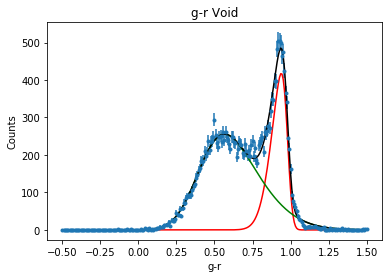

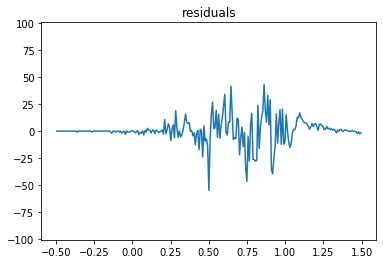

41
loading property model variables


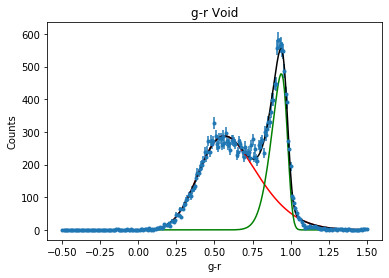

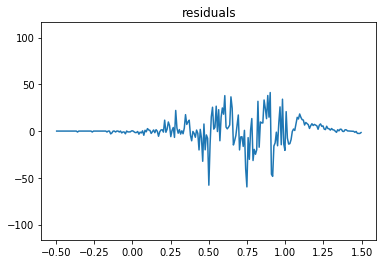

42
loading property model variables
43
loading property model variables


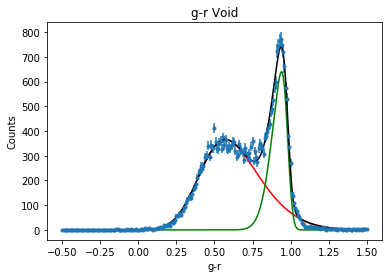

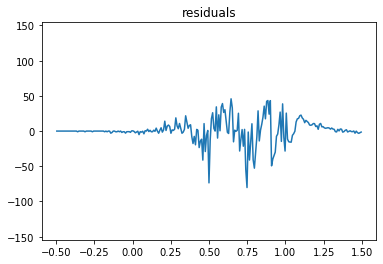

44
loading property model variables


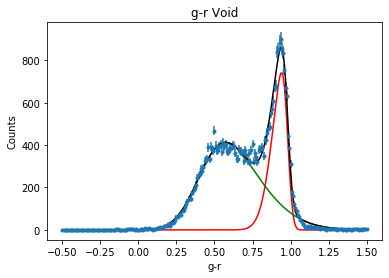

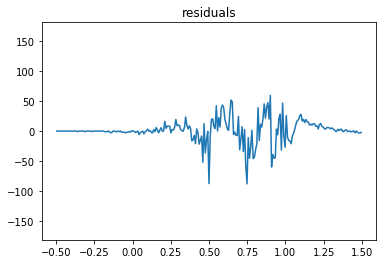

45
loading property model variables


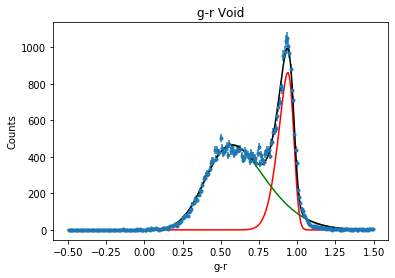

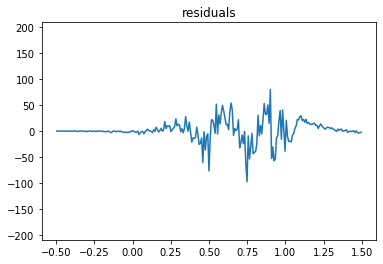

46
loading property model variables


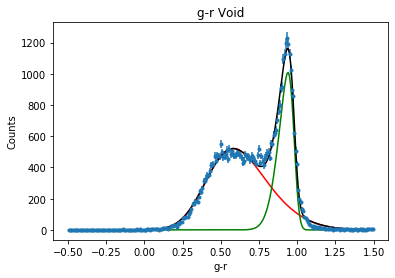

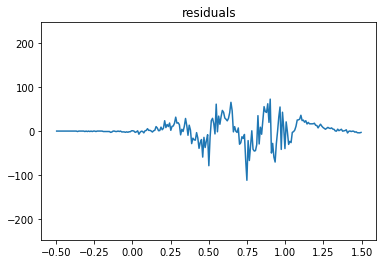

47
loading property model variables


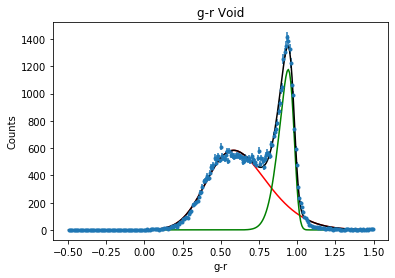

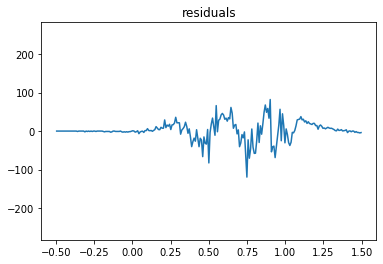

48
loading property model variables


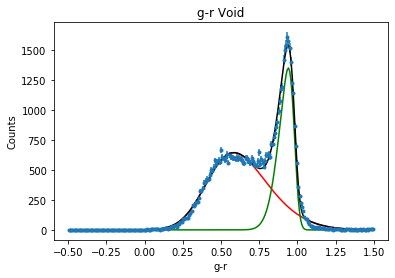

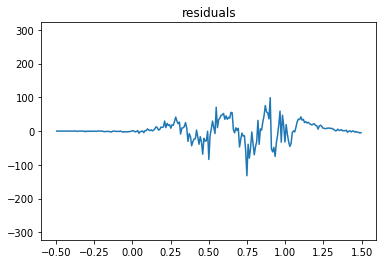

49
loading property model variables


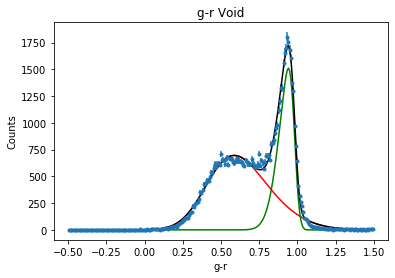

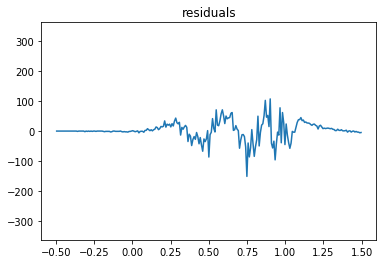

50
loading property model variables


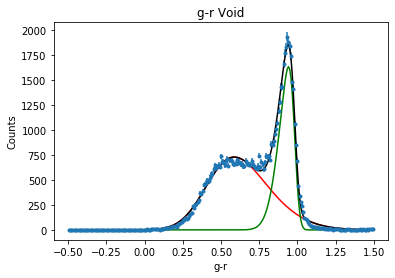

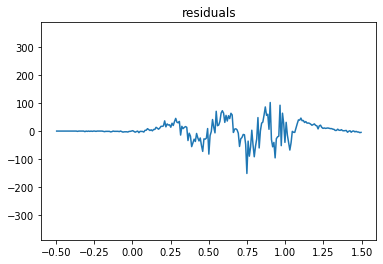

51
loading property model variables


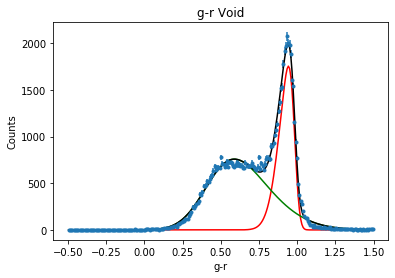

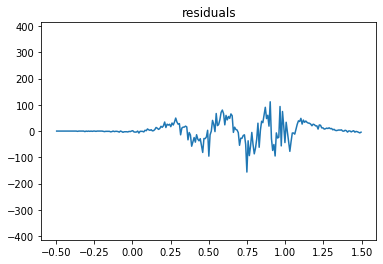

In [85]:
#non_normalized by the general distribution = nn
amplitude_ratio_nn = []
amplitude_ratio_err_nn = []

amplitude_diff_nn = []
amplitude_diff_err_nn = []
for i in range(len(ind_gal_depth_voidv2)):
    print(i)
    try:
        temp = bimodal_fit_void_separate(g_r[np.asarray(list(ind_gal_depth_voidv2[i]), dtype=int).flatten()], 'g-r', bins_=np.linspace(-0.5,1.5, 250))
        x = np.max([temp[0][4],temp[0][0]])
        y = np.min([temp[0][4],temp[0][0]])
        if x == temp[0][4]:
            dx = temp[1][4]
            dy = temp[1][0]

        if x == temp[0][0]:
            dx = temp[1][0]
            dy = temp[1][4]
            
        
        amplitude_ratio_nn.append(x/y)
        amplitude_diff_nn.append(x-y)
        amplitude_ratio_err_nn.append(ampl_ratio_err(x,dx,y,dy))
        amplitude_diff_err_nn.append(ampl_diff_err(dx,dy))
        
    except (RuntimeError):
        pass


In [96]:
# voidfinder line
x_vf_void_nn = np.max([VF_void[0][4],VF_void[0][0]])
y_vf_void_nn = np.min([VF_void[0][4],VF_void[0][0]])
if x_vf_void_nn == VF_void[0][4]:
    dx_vf_void_nn = VF_void[1][4]
    dy_vf_void_nn = VF_void[1][0]

if x_vf_void_nn == VF_void[0][0]:
    dx_vf_void_nn = VF_void[1][0]
    dy_vf_void_nn = VF_void[1][4]

vf_void_ratio_nn = x_vf_void_nn/y_vf_void_nn
vf_void_diff_nn = (x_vf_void_nn-y_vf_void_nn)
vf_void_ratio_err_nn= (ampl_ratio_err(x_vf_void_nn,dx_vf_void_nn,y_vf_void_nn,dy_vf_void_nn))
vf_void_diff_err_nn= (ampl_diff_err(dx_vf_void_nn,dy_vf_void_nn))

In [97]:
ind_ratio_nn=8 # choose
x_ratio_nn = np.linspace(0,len(amplitude_ratio_nn[ind_ratio_nn:]),len(amplitude_ratio_nn[ind_ratio_nn:]))

ind_diff_nn=8 # choose
x_diff_nn = np.linspace(0,len(amplitude_diff_nn[ind_diff_nn:]),len(amplitude_diff_nn[ind_diff_nn:]))

In [100]:
y_vf_void_ratio_nn = []
y_vf_void_ratio_err_nn=[]
for i in range(len(x_ratio_nn)):
    y_vf_void_ratio_nn.append(vf_void_ratio_nn)
    y_vf_void_ratio_err_nn.append(vf_void_ratio_err_nn)
    
y_vf_void_diff_nn = []
y_vf_void_diff_err_nn=[]
for i in range(len(x_diff_nn)):
    y_vf_void_diff_nn.append(vf_void_diff_nn)
    y_vf_void_diff_err_nn.append(vf_void_diff_err_nn)

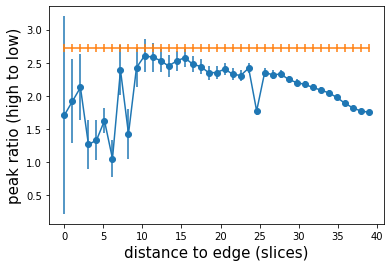

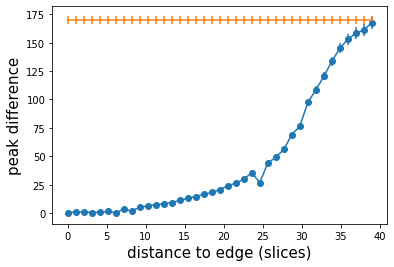

In [101]:
plt.errorbar(x_ratio_nn,amplitude_ratio_nn[ind_ratio_nn:],yerr=amplitude_ratio_err_nn[ind_ratio_nn:] ,fmt= '-o')
plt.errorbar(x_ratio_nn,y_vf_void_ratio_nn,yerr=y_vf_void_ratio_err_nn)

plt.xlabel("distance to edge (slices)",fontsize=15)
plt.ylabel("peak ratio (high to low)",fontsize=15)
plt.show()


plt.errorbar(x_diff_nn,amplitude_diff_nn[ind_diff_nn:],yerr=amplitude_diff_err_nn[ind_diff_nn:] ,fmt= '-o')
plt.errorbar(x_diff_nn,y_vf_void_diff_nn,yerr=y_vf_void_diff_err_nn)

# error bars get bigger as x,y gets bigger
plt.xlabel("distance to edge (slices)",fontsize=15)
plt.ylabel("peak difference",fontsize=15)
plt.show()

In [116]:
# double check ratio calculation
# calculate are under the curve and take the ratio 
# make slices that have the same amount of galaxies in them 
# make the x-axis clearer so it goes from 0 to 1 as in the depth normalization 
# are the voids that are not included int he V2 depth calculation affecting the distribution we see? no because the last slice does look like the general distribution
# why does the normalization fail? 